## Include Install of Necessary Libraries
* matplotlib for visualizations
* numpy for array manipulation
* pandas for importing data and manipulating in memory
* scikit-learn for classic machine learning methods
* ipympl to enable interactivity in Jupyter
* seaborn for nice looking visuals
* pyarrow for fast access to numpy arrays
* scipy for basic statistics and bootsrapping
* polars for effecient loading from parquet file
* openpyxl to export data frames to Excel file

In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install -U scikit-learn
!pip install ipympl
!pip install seaborn
!pip install pyarrow
!pip install scipy
!pip install polars
!pip install openpyxl

## Import All Necessary Libraries and Set Defaults

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import bootstrap
import scipy.stats as stats
from scipy.stats import mannwhitneyu

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import polars as pl
import warnings
import datetime

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.7f}'.format
np.random.seed(42)

## Create all Functions

In [37]:
def create_box_and_hist(data, column):
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(4, 4), gridspec_kw={"height_ratios": (.85, .15)})
    ax_hist.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax_hist.set_title('Histogram')
    ax_hist.set_xlabel(f'# {column}')
    ax_box.boxplot(data[column], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='orange'))
    ax_box.set_xticks([])
    ax_box.set_yticks([])
    plt.tight_layout()
    plt.show()

def boot(data, column, stat, stat_label=''):
    rnd = 42
    res = bootstrap((data[column].values,), stat, confidence_level=0.9,
                    random_state=rnd, batch=1, n_resamples=20000)
    #fig, ax = plt.subplots()
    #ax.hist(res.bootstrap_distribution, bins=25)
    #ax.set_title('Bootstrap Distribution')
    #ax.set_xlabel(stat_label)
    #ax.set_ylabel('frequency')
    #plt.show()
    return res

def histo(df):
    df.hist()
    plt.tight_layout()
    plt.show()

def mannwhitu(column):
    statistic, p_value = mannwhitneyu(df_outliers[column], df[df.iso != -1 ][column], alternative='greater')
    print(f"Statistic for: {column}", statistic)
    print(f"p-value: for: {column}", p_value)
    print(f"")

def compare_sets(column):
    A = boot(df, column, np.mean)
    B = boot(df_outliers, column, np.mean)
    
    ax1 = plt.hist(A.bootstrap_distribution, bins=100, label='Non-Outliers')
    ax2 = plt.hist(B.bootstrap_distribution, bins=100, label='Outliers')
    
    plt.title(f'Comparing Final Set of Users for Feature: {column}')
    plt.legend(loc='upper center')

    #plt.savefig(f'compare_{column}.png', bbox_inches='tight')
    plt.show()
    print(A.confidence_interval)
    print(B.confidence_interval)

## Run once and then comment out to get a parquet file for further re-runs.

In [4]:
# dfreco = pd.read_csv("recommendations.csv")
# dfreco.to_parquet("recommendations.parquet")

## Load data from parquet file to a polars data frame

In [5]:
dfreco = pl.read_parquet("recommendations.parquet")#.set_index('review_id')

In [6]:
original_user_count = len(dfreco)

In [7]:
dfreco.to_pandas().describe()

,app_id,helpful,funny,hours,user_id,review_id
count,"41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000"
mean,"603,272.3585402",3.2025669,1.0580709,100.6022378,"7,450,576.0049239","20,577,396.5000000"
std,"472,923.2816550",46.9364857,28.6706028,176.1675413,"4,010,685.0333110","11,880,365.8415090"
min,10.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
25%,"253,940.0000000",0.0000000,0.0000000,7.8000000,"4,287,256.0000000","10,288,698.2500000"
50%,"435,150.0000000",0.0000000,0.0000000,27.3000000,"7,546,445.5000000","20,577,396.5000000"
75%,"933,110.0000000",0.0000000,0.0000000,99.2000000,"10,968,770.7500000","30,866,094.7500000"
max,"2,253,290.0000000","36,212.0000000","28,109.0000000","1,000.0000000","14,306,063.0000000","41,154,793.0000000"


In [8]:
dfreco.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


## Summarize the data to the user level

In [9]:
df = dfreco.to_pandas().groupby('user_id').agg({'helpful':'sum', 'funny':'sum', 'app_id': 'nunique', 'is_recommended':'sum', 'hours':'sum'}).rename(columns={'app_id': 'products', 'is_recommended':'recommended'})

In [10]:
summarized_user_count = len(df)

In [11]:
df.describe()

,helpful,funny,products,recommended,hours
count,"13,781,059.0000000","13,781,059.0000000","13,781,059.0000000","13,781,059.0000000","13,781,059.0000000"
mean,9.5639224,3.1597490,2.9863288,2.5618059,300.4315106
std,126.4814068,58.3653193,8.1180071,6.5223299,516.2289609
min,0.0000000,0.0000000,1.0000000,0.0000000,0.0000000
25%,0.0000000,0.0000000,1.0000000,1.0000000,28.6000000
50%,0.0000000,0.0000000,1.0000000,1.0000000,114.6000000
75%,2.0000000,0.0000000,3.0000000,2.0000000,388.4000000
max,"70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","290,694.2000000"


## Clean Data

Several anomalies exists. Some hours played seem to high and we don't want any records that has any value that is equal to zero. We don't want any records where the count of recommendations is somehow hiagher than the number of products reviewed. The number or products should also at least be greater than 10.

In [12]:
# Max hours seems high, let's constrain to only hours that would fall within the date range of the platform life
data1 = datetime.datetime(2003, 1, 1, 0, 0, 0) #First Possible Launch of Steam
data2 = datetime.datetime.now() 

diff = data2 - data1
hours = diff.days * 24 + diff.seconds // 3600
df = df[df.hours <= hours]

# We do not want any users with any value less than or equal to 0
df = df[(df.helpful > 0)&(df.funny > 0)&(df.recommended > 0)&(df.recommended < df.products)&(df.products>10)]

In [13]:
df.describe()

,helpful,funny,products,recommended,hours
count,"288,203.0000000","288,203.0000000","288,203.0000000","288,203.0000000","288,203.0000000"
mean,178.2848791,54.1608068,29.2476553,22.9921722,"1,696.9247714"
std,677.0903955,262.5172918,41.9713363,31.5993966,"1,616.1594908"
min,2.0000000,2.0000000,11.0000000,1.0000000,3.1000000
25%,19.0000000,4.0000000,14.0000000,11.0000000,705.7000000
50%,49.0000000,10.0000000,20.0000000,15.0000000,"1,314.1000000"
75%,136.0000000,31.0000000,31.0000000,25.0000000,"2,212.1000000"
max,"70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","73,729.9000000"


## Train PCA with one component on all features to see if it makes sense

In [14]:
features = ['products','helpful','funny', 'hours', 'recommended']
X = df[features].values

scaler = StandardScaler()
X = scaler.fit_transform(X)


pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['single_pca'] = pca_result[:,0]

In [15]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance with Hours")

,products,helpful,funny,hours,recommended
0,0.547625,0.425838,0.283434,0.368299,0.550264


#### After reviewing the feature importances, we should check out correlation and other issues and remove what doesn't make sense. We notice also that hours importance is unexpectedly high and is really not relevant to our problem, so we will remove that.

In [16]:
features = ['products','helpful','funny', 'hours', 'recommended']
df[features].corr().style.background_gradient(cmap='coolwarm')

,products,helpful,funny,hours,recommended
products,1.000000,0.396414,0.153508,0.400030,0.904623
helpful,0.396414,1.000000,0.524337,0.216647,0.402085
funny,0.153508,0.524337,1.000000,0.139482,0.154581
hours,0.400030,0.216647,0.139482,1.000000,0.410345
recommended,0.904623,0.402085,0.154581,0.410345,1.000000


#### Here recommended is too strongly correlated, we should remove this.

In [17]:
features = ['products','helpful','funny']
df[['products','helpful','funny']].corr().style.background_gradient(cmap='coolwarm')

,products,helpful,funny
products,1.000000,0.396414,0.153508
helpful,0.396414,1.000000,0.524337
funny,0.153508,0.524337,1.000000


#### All feature correlations are within acceptable range.

## Based on the three features we chose, train a single PCA component.

In [18]:
X = df[features].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['single_pca'] = pca_result[:,0]
#df['single_pca_sort'] = df.single_pca.abs()


In [19]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance without Hours")

,products,helpful,funny
0,0.477781,0.665498,0.573444


#### Here Helpul and funny are the highest weighted components followed by number of products. This is our new column for sorting.

### View histogram of our data and take everything greater than the 95th percentile.

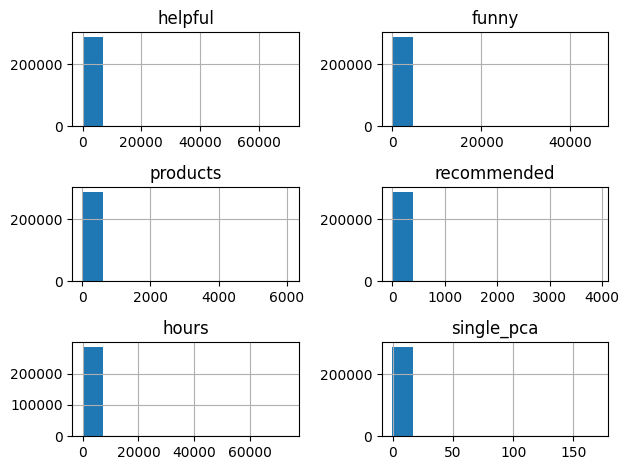

In [20]:
histo(df)

df = df[df['single_pca'] >= np.percentile(df['single_pca'].values, 95)]

#### Heavily skewed as expected on all features.

In [21]:
df.describe()

,helpful,funny,products,recommended,hours,single_pca
count,"14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000"
mean,"1,664.1317049",547.2455763,108.4307820,83.6974533,"3,644.8849906",3.4388915
std,"2,534.4331890","1,032.5260715",151.4160332,109.0639356,"3,790.9696699",4.4977442
min,2.0000000,2.0000000,11.0000000,1.0000000,3.1000000,1.2029809
25%,573.0000000,100.0000000,32.0000000,25.0000000,"1,579.4500000",1.5633257
50%,"1,038.0000000",290.0000000,72.0000000,56.0000000,"2,757.6000000",2.1581450
75%,"1,796.0000000",652.5000000,140.0000000,107.0000000,"4,548.5500000",3.5791840
max,"70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","73,729.9000000",170.6271395


## Train Machine Learning Algorithm: Isolation Forest to find outliers.
* The contamination parameter should be set to an apprpriate value. Here 5% will get enough outliers.
* Add the scores and outlier type indicator to teh data frame

In [22]:
X = df[features].values
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X)
scores = iso.decision_function(X)

df["iso"] = outliers
df["iso_score"]  = scores
df['type'] = df['iso'].apply(lambda x: "Outlier" if x == -1 else "Inlier")

## Let's view a 2 component PCA to see how the outliers differ

In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
sns_order = ['Outlier', 'Inlier']

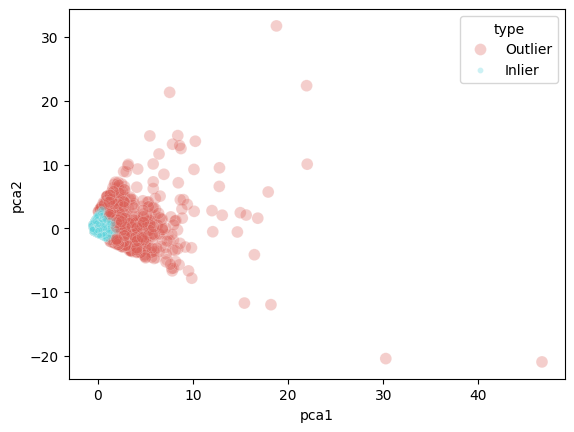

In [24]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)

df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="pca1", 
    y="pca2", 
    hue="type",
    hue_order = sns_order,
    legend=True,
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

In [25]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance without Hours")

,products,helpful,funny
0,0.316174,0.724929,0.611974
1,0.856654,0.059021,-0.512503


#### The PCA component feature importances agree with the single PCA finding. The trend of outluiers to be to teh right of the distribution is as expected.

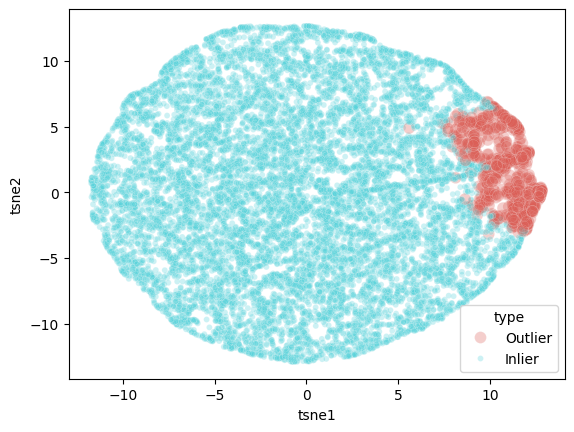

In [26]:
tsne = TSNE(n_components=2, perplexity=40, max_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X)

df['tsne1'] = tsne_results[:,0]
df['tsne2'] = tsne_results[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="tsne1", 
    y="tsne2", 
    hue="type",
    hue_order = sns_order,
    legend="full",
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

#### Here the t-SNE version of the diagram agrees with the PCA version. We see the outliers to the right of the distribution.

## Create the outliers data frame

In [27]:
df_outliers = df[df.iso == -1]
#df_outliers = df_outliers[df_outliers.hours <= hours]

cols = ['user_id', 'products','helpful','funny', 'hours', 'recommended']
df_outliers = df_outliers.sort_values(by='single_pca', ascending=False)#['products','helpful','funny', 'hours', 'recommended'], ascending=False)
df_outliers.reset_index(inplace=True)
df_outliers.index = np.arange(1, len(df_outliers)+1)
df_outliers.head()

,user_id,helpful,funny,products,recommended,hours,single_pca,iso,iso_score,type,pca1,pca2,tsne1,tsne2
1,5860500,70096,46186,129,107,"3,922.6000000",170.6271395,-1,-0.2309258,Outlier,46.6681606,-20.9439218,12.7832403,0.3721867
2,11934022,16771,43867,237,209,"34,287.9000000",114.3788181,-1,-0.2159250,Outlier,30.2659919,-20.4236440,12.8015671,0.2756441
3,5112758,42745,3510,4152,3920,"8,404.2000000",96.3183793,-1,-0.2685615,Outlier,21.9506633,22.3638485,11.6303091,4.5884366
4,11764552,14962,4906,6045,191,"24,249.1000000",93.6094492,-1,-0.2595497,Outlier,18.7839366,31.7341292,11.5750313,4.7596078
5,8040965,65990,1132,1673,1633,"7,642.1000000",85.7511666,-1,-0.2573119,Outlier,22.0136051,10.0598447,12.1240158,3.1214142


In [28]:
df_outliers[cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 1 to 721
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      721 non-null    int64  
 1   products     721 non-null    int64  
 2   helpful      721 non-null    int64  
 3   funny        721 non-null    int64  
 4   hours        721 non-null    float64
 5   recommended  721 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 39.4 KB


#### Important here is that we have enough users at 721. This is less than a thousand.

In [29]:
df_outliers[cols].drop('user_id', axis=1).describe()

,products,helpful,funny,hours,recommended
count,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000
mean,358.3952843,"8,152.1026352","2,628.6338419","6,333.9284327",259.4882108
std,506.0913460,"7,587.7165466","3,499.7779559","7,652.6881362",344.3370687
min,11.0000000,20.0000000,2.0000000,141.1000000,1.0000000
25%,42.0000000,"3,306.0000000",516.0000000,"2,339.1000000",35.0000000
50%,176.0000000,"6,762.0000000","1,735.0000000","4,269.1000000",139.0000000
75%,527.0000000,"10,542.0000000","3,735.0000000","7,438.7000000",353.0000000
max,"6,045.0000000","70,096.0000000","46,186.0000000","73,729.9000000","3,920.0000000"


In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_outliers[cols].style.format(precision=2))

,user_id,products,helpful,funny,hours,recommended
1,5860500,129,70096,46186,3922.60,107
2,11934022,237,16771,43867,34287.90,209
3,5112758,4152,42745,3510,8404.20,3920
4,11764552,6045,14962,4906,24249.10,191
5,8040965,1673,65990,1132,7642.10,1633
6,9231134,1056,53730,2310,7558.60,762
7,9581059,38,16109,24541,3577.60,35
8,8865664,879,39597,7905,8199.50,872
9,5157631,625,23828,15811,8957.20,596
10,11451103,620,44896,4202,16059.40,563


In [31]:
features = ['products','helpful','funny', 'hours', 'recommended']
print("Outliers")
print(df_outliers[features].median()) 
print("")
print("Sample")
print(df[features].median()) 

Outliers
products        176.0000000
helpful       6,762.0000000
funny         1,735.0000000
hours         4,269.1000000
recommended     139.0000000
dtype: float64

Sample
products         72.0000000
helpful       1,038.0000000
funny           290.0000000
hours         2,757.6000000
recommended      56.0000000
dtype: float64


#### Here we see the outlier medians compared to the sample they were taken from's medians. You can see that every column in the outliers lies to the right of the original.

## View side by side histograms for each feature's distribution from both outlier and non-outlier distributions.

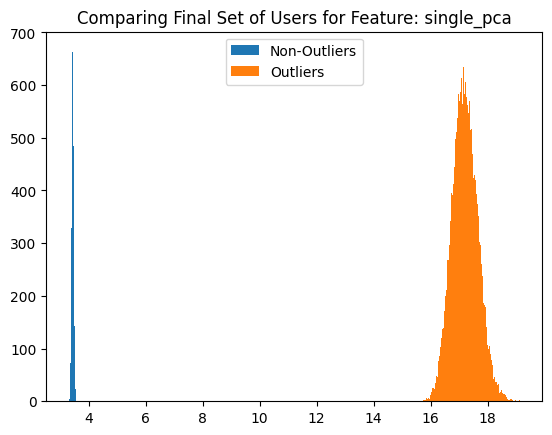

ConfidenceInterval(low=3.381901397593155, high=3.504982883109117)
ConfidenceInterval(low=16.54132622983158, high=18.072200324088072)


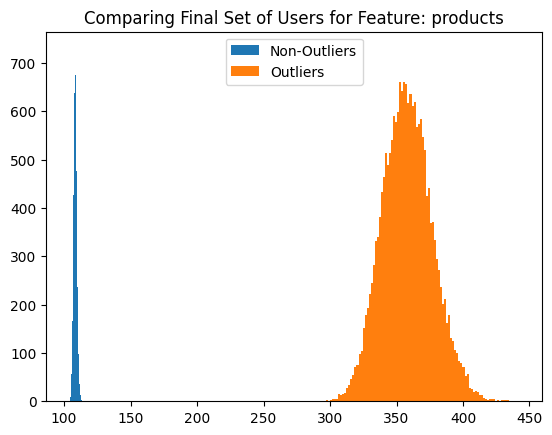

ConfidenceInterval(low=106.51208779348127, high=110.68873865278981)
ConfidenceInterval(low=330.6254717499424, high=393.7222687065267)


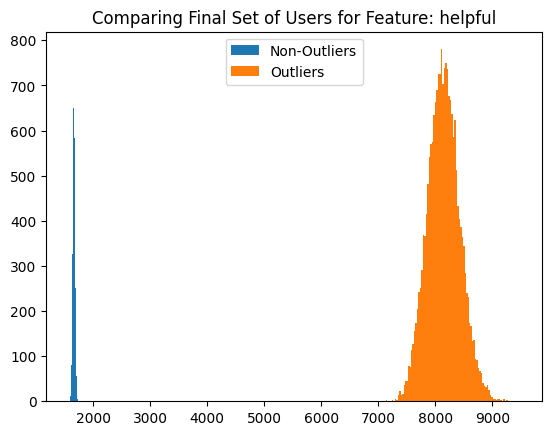

ConfidenceInterval(low=1631.551560460802, high=1700.5495283147998)
ConfidenceInterval(low=7717.652483552678, high=8665.362246010143)


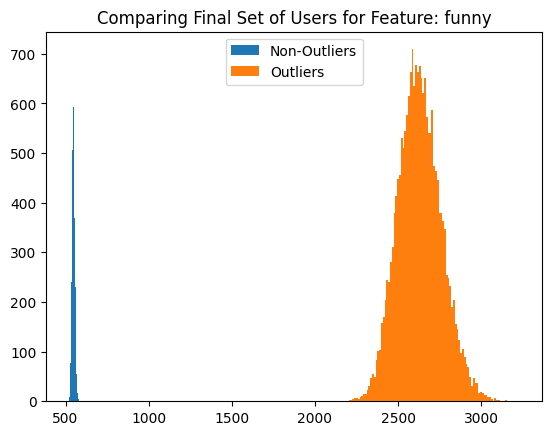

ConfidenceInterval(low=534.2152168564315, high=562.6842106337313)
ConfidenceInterval(low=2441.4760344291444, high=2880.7166225864694)


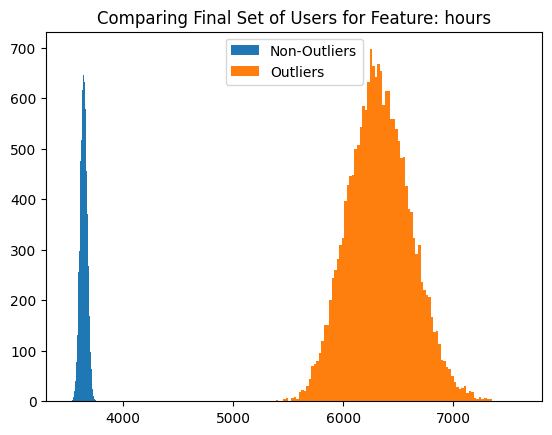

ConfidenceInterval(low=3594.5765271784326, high=3698.850078276228)
ConfidenceInterval(low=5914.216295943069, high=6858.510772048295)


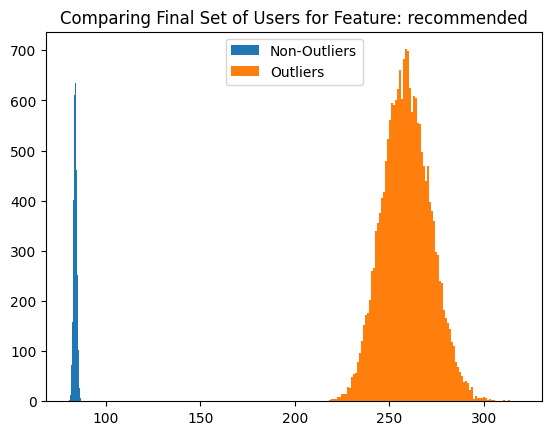

ConfidenceInterval(low=82.28717441077792, high=85.2748059774997)
ConfidenceInterval(low=240.49341513672053, high=282.8663664945586)


In [38]:
features = ['single_pca','products','helpful','funny','hours','recommended']
for f in features:
    compare_sets(f)


## Perform the Mann-Whitney U test using a bootstraps of the means for outlier and non-outlier groups.

In [33]:
for f in features:
    mannwhitu(f)

Statistic for: single_pca 9850666.0
p-value: for: single_pca 0.0

Statistic for: products 6685734.5
p-value: for: products 1.8213063322150473e-58

Statistic for: helpful 8958617.5
p-value: for: helpful 3.262617862084321e-299

Statistic for: funny 8058045.0
p-value: for: funny 3.2335959833346005e-181

Statistic for: hours 6439751.0
p-value: for: hours 9.891581253673747e-44

Statistic for: recommended 6726583.5
p-value: for: recommended 3.973164451619573e-61



In [41]:
print(f'Original recommendations count: {original_user_count:,}')
print(f'Summarized user count: {summarized_user_count:,}')
print(f'User candidate count: {len(df):,}')
print(f'Anomaly user count: {len(df_outliers):,}')

Original recommendations count: 41,154,794
Summarized user count: 13,781,059
User candidate count: 14,411
Anomaly user count: 721


#### Here the funnel of users from the original to the final list

## Export the file to Excel

In [36]:
df_outliers.to_excel('impactful_users.xlsx')